# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material is an extract and slight rewrite by Alan Edelman of a wonderful lecture by Steven Johnson at MIT: 
https://github.com/mitmath/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.12890415003200417
 0.11517291092858883
 0.6639878724290809
 0.10437480682002331
 0.0049677986668730245
 0.6395804648726999
 0.819770383302504
 0.2692585997408796
 0.6683990582182938
 0.03869188858075201
 0.2634991111841113
 0.5540901364563016
 0.9447233640467362
 ⋮
 0.08802198016277374
 0.9364043043965401
 0.5667135965969899
 0.4881002480884842
 0.38929390566851174
 0.4795761151195137
 0.6142796360724794
 0.32958284937056836
 0.24240971945028433
 0.32148708580736385
 0.09113349597358678
 0.844594635251666

In [2]:
sum(a) # Remember 5,000,946 .5

4.998815618102642e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [3]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [4]:
using Libdl

In [5]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):


#open(`gcc  -fPIC -O3   -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
open(`gcc  -fPIC -O3 -ffast-math  -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

4.998815618102875e6

In [7]:
c_sum(a) - sum(a) # Compare the c_sum with the julia built in sum

2.3283064365386963e-7

In [8]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb  

true

In [9]:
≈  # alias for the `isapprox` function 

isapprox (generic function with 9 methods)

In [10]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [11]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 771 samples with 1 evaluation.
 Range (min … max):  5.848 ms … 27.029 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.121 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.473 ms ±  1.363 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▄▅▄▄▃▂▂▁   ▁                                              
  ██████████████▅██▇▄▁▅▆▄▇▄▇▅▄▅▁▆▅▅▄▆▅▄▄▁▆▁▁▄▅▁▅▅▆▁▁▁▁▁▄▄▁▄▅ ▇
  5.85 ms      Histogram: log(frequency) by time     10.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
c_bench.times  # m=miliseconds = 10^(-3)  μ=microseconds = 10^(-6)  n = nanoseconds = 10^(-9)

771-element Vector{Float64}:
 6.176154e6
 6.037457e6
 6.191128e6
 5.879539e6
 6.577911e6
 6.181641e6
 6.463947e6
 5.867774e6
 6.270155e6
 6.035151e6
 6.38937e6
 5.864417e6
 6.137813e6
 ⋮
 5.859737e6
 5.890949e6
 6.336221e6
 5.861663e6
 5.868657e6
 5.959543e6
 5.853901e6
 5.870438e6
 5.851739e6
 5.857156e6
 5.876536e6
 5.854868e6

In [13]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec") 

C: Fastest time was 5.848301 msec


In [14]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 5.8483

In [15]:
using Plots
gr()

Plots.GRBackend()

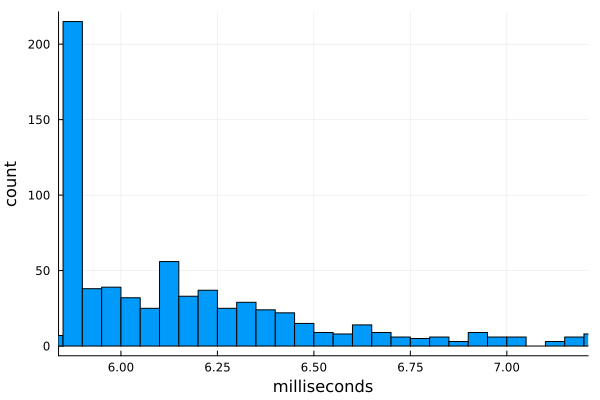

In [16]:
using Statistics

t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [17]:
#]add PyCall

In [18]:
using PyCall

In [19]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [20]:
pysum(a)

4.998815618102199e6

In [21]:
pysum(a) ≈ sum(a)

true

In [22]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  619.152 ms … 629.667 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     625.224 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   624.214 ms ±   3.189 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁          ▁    ▁      ▁           ▁█      ▁                ▁  
  █▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  619 ms           Histogram: frequency by time          630 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [23]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 2 entries:
  "C"               => 5.8483
  "Python built-in" => 619.152

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [24]:
# using Pkg

In [25]:
# Pkg.add("Conda")

In [26]:
using Conda 
#Conda.add("numpy")

In [27]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 933 samples with 1 evaluation.
 Range (min … max):  4.604 ms … 12.421 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.811 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.345 ms ±  1.430 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇▆▄▃▂▂                                                     
  ███████▇█▇▇▅▄▁▆▁▅▆▁▅▅▅▅▅▁▅▄▅▅▅▅▅▇▇▆▆▆▇▅▁▅▅▅▅▄▁▄▁▄▅▄▄▅▅▄▄▁▅ █
  4.6 ms       Histogram: log(frequency) by time     11.5 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [28]:
numpy_sum(a) 

4.998815618102639e6

In [29]:
numpy_sum(a) ≈ sum(a)

true

In [30]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 5.8483
  "Python numpy"    => 4.60358
  "Python built-in" => 619.152

# 4. Python, hand-written

In [31]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f686d9f2dd0>

In [32]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  849.328 ms … 909.836 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     885.636 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   883.604 ms ±  20.649 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                           ██              ██              █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  849 ms           Histogram: frequency by time          910 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [33]:
sum_py(a)

4.998815618102199e6

In [34]:
sum_py(a) ≈ sum(a)

true

In [35]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                   => 5.8483
  "Python numpy"        => 4.60358
  "Python hand-written" => 849.328
  "Python built-in"     => 619.152

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [36]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:994

In [37]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 341 samples with 1 evaluation.
 Range (min … max):   4.669 ms … 52.063 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.667 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.663 ms ± 10.649 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                                                           
  ██▅▄▄▃▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▃▂▃▄▃▃▃▃▃▄▃▃▄▃▃▂▃▃▃▃▂▃▃▂▂▁▃▁▁▁▂▁▂▁▁▁▁▂ ▃
  4.67 ms         Histogram: frequency by time        44.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [38]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 5.8483
  "Python numpy"        => 4.60358
  "Python hand-written" => 849.328
  "Python built-in"     => 619.152
  "Julia built-in"      => 4.66936

# 6. Julia (hand-written)

In [39]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    #@inbounds @simd for a in A
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [40]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 151 samples with 1 evaluation.
 Range (min … max):  25.100 ms … 39.763 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     33.410 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   33.179 ms ±  2.215 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂     ▁▂ ▂▅▂▄▄▄█ ▄▂▁▅             
  ▃▁▁▃▁▁▁▁▁▁▁▃▁▃▁▁▁▃▁▃▃▅▅▅▆▁▃████▆▅██▆████████████▃▃▃▃▅▃▆▃▃▃▃ ▃
  25.1 ms         Histogram: frequency by time        37.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 5.8483
  "Python numpy"        => 4.60358
  "Julia hand-written"  => 25.0999
  "Python hand-written" => 849.328
  "Python built-in"     => 619.152
  "Julia built-in"      => 4.66936

 # 7. Julia hand-written ++

In [42]:
function myfastsum(A)   
    s = 0.0  # s = zero(eltype(A))
    @inbounds @simd for a in A  # <-- don't check bounds, parallel on processor
        s += a
    end
    s
end

myfastsum (generic function with 1 method)

In [43]:
j_bench_hand_pp = @benchmark myfastsum($a)

BenchmarkTools.Trial: 205 samples with 1 evaluation.
 Range (min … max):   6.897 ms … 45.305 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.811 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.420 ms ±  6.976 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                     ▅ ▃▂▃▅ ▃▃   ▅  ▂ █  ▃▇▅ ▄▂                
  ▅▅▅▃▅▃▅▃▁▁▁▁▃▃▃▅▅████████▆████▆██▆███▆▆███▇██▅▆▃▁▁▁▁▁▅▅▁▁▁▃ ▅
  6.9 ms          Histogram: frequency by time        41.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia hand-written-pp"] = minimum(j_bench_hand_pp.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written-pp" => 6.89723
  "C"                     => 5.8483
  "Python numpy"          => 4.60358
  "Julia hand-written"    => 25.0999
  "Python hand-written"   => 849.328
  "Python built-in"       => 619.152
  "Julia built-in"        => 4.66936

# Summary

In [45]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

C........................5.8
Julia built-in...........4.7
Julia hand-written......25.1
Julia hand-written-pp.....6.9
Python built-in........619.2
Python hand-written....849.3
Python numpy.............4.6


In [46]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

Python numpy...............4.6
Julia built-in............4.67
C.........................5.85
Julia hand-written-pp.......6.9
Julia hand-written........25.1
Python built-in.........619.15
Python hand-written.....849.33


In [47]:
using LinearAlgebra

In [48]:
n=10000
a = [rand(1,3) for i=1:n]
b = [rand(3) for i=1:n]
dist(x,y) = norm(x-y)
@time dist.(a',b)

 13.516439 seconds (100.90 M allocations: 8.254 GiB, 7.88% gc time, 14.17% compilation time)


10000×10000 Matrix{Float64}:
 0.533594  0.542728  0.760435  0.687151  …  0.421058   0.510531  0.861942
 0.717423  0.403549  0.519785  0.149457     0.577439   0.667605  0.457394
 0.873479  0.456144  0.300576  0.420673     1.03561    0.865008  0.933639
 1.12385   0.792904  0.950594  0.597199     0.59287    1.06286   0.345701
 0.878739  0.552197  0.719356  0.37144      0.470774   0.822198  0.352808
 0.782847  0.418825  0.529277  0.182215  …  0.610157   0.735672  0.474555
 0.258852  0.547059  0.668542  0.577472     0.598057   0.211674  0.803627
 0.25498   0.684545  0.651739  0.577348     0.913138   0.217752  0.865048
 0.662543  0.204378  0.457769  0.351289     0.490978   0.634504  0.694041
 1.08385   0.924989  1.02454   0.61802      0.741358   1.01243   0.149869
 0.373117  0.319657  0.401878  0.560704  …  0.762862   0.399135  0.99801
 0.225652  0.572836  0.590979  0.481808     0.769629   0.160994  0.769803
 0.945591  0.423043  0.666832  0.659885     0.587316   0.930434  0.925131
 ⋮        